# Machine Learning Methods for Empirical Dynamic Modeling

_Kevin Siswandi | July 2020_

We demonstrate a few approaches for empirical dynamic modeling with machine learning tools:
* One-step Learning
* LmmNet
* Recurrent Neural Network (maybe)

Here we will demonstrate it on the canonical 3-D Linear Oscillator. Later, we will try to see how it performs with noisy data. Finally, we see how the method can extract insights from what it has learnt from data.

In [2]:
import sys
sys.path.append("./source")

# libraries for this project
from lmmNet import *
import linear
import train_onestep
import predict_onestep
import predict_lmmNet

import numpy as np
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

The dynamics of the test problem considered here is given by the linear ODE:

<img src=image/linear-equation.png alt="drawing" align ="centre" width="300"/>   
with the initial condition $(x_0, y_0, z_0) = (2,0,1)$.

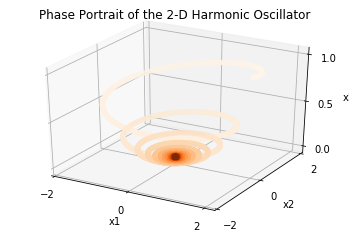

In [11]:
time_points, linear_data = linear.simulate_custom()

# Phase portrait
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(linear_data[0,:,0], linear_data[0,:,1], linear_data[0,:,2], c=time_points, cmap='Oranges')
#ax.grid(False)
ax.set_title('Phase Portrait of the 3-D Linear System')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_xticks([-2,0, 2 ])
ax.set_yticks([-2,0, 2 ])
ax.set_zticks([0, 0.5, 1])
plt.show()

## 1. LmmNet

Training is done to find the optimal parameters via minimising loss function:

$$ \arg \min_w \frac{1}{N - M + 1} \sum_{n = M}^{N} |\textbf{y}_n|^2 $$

where N is the number of data points and M multi steps. The linear difference/residual operator is defined as

$$ \textbf{y}_n = \sum_{n=0}^M \left(\alpha_m x_{n-m} + h \beta_m \textbf{f}(\textbf{x}_{n-m}) \right)$$

for $n=M,...,N$.

In [13]:
# we specify a LMM scheme and number of steps
dt = time_points[1] - time_points[0]
M = 1
scheme = 'AM'
model = lmmNet(dt, linear_data, M, scheme, hidden_units=256)

N_Iter = 10000
model.train(N_Iter, debug=False)

In [14]:
x0 = linear_data[0,0,:] # initial conditions
predicted_traj = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), x0, time_points)

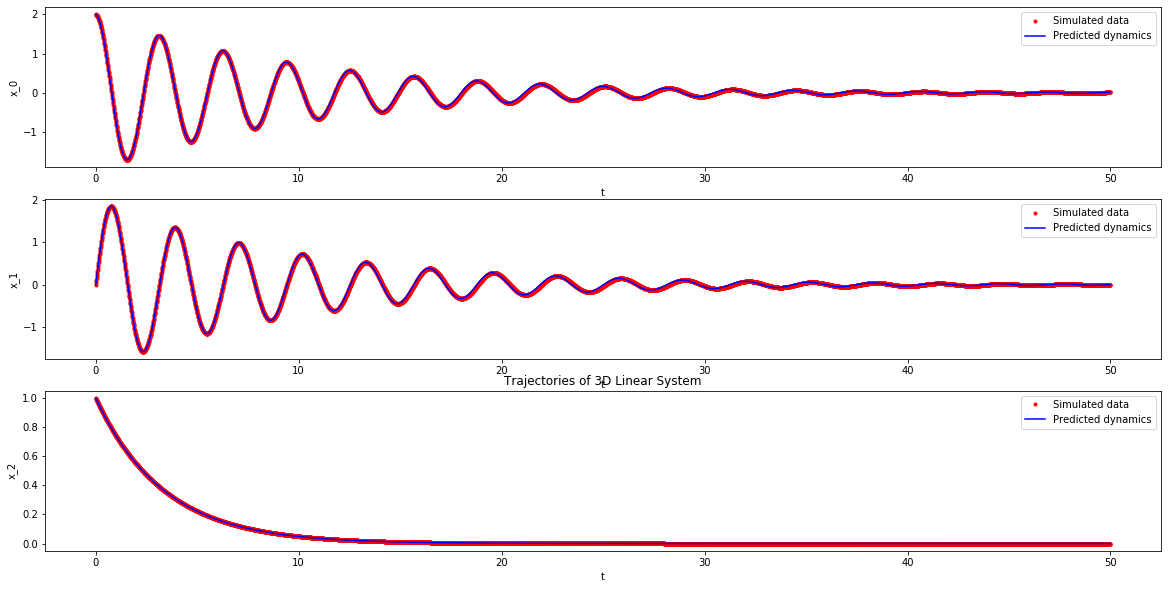

In [16]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(3):
    plt.subplot(3,1,species + 1)
    plt.plot(time_points, linear_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 3D Linear System')
plt.show()

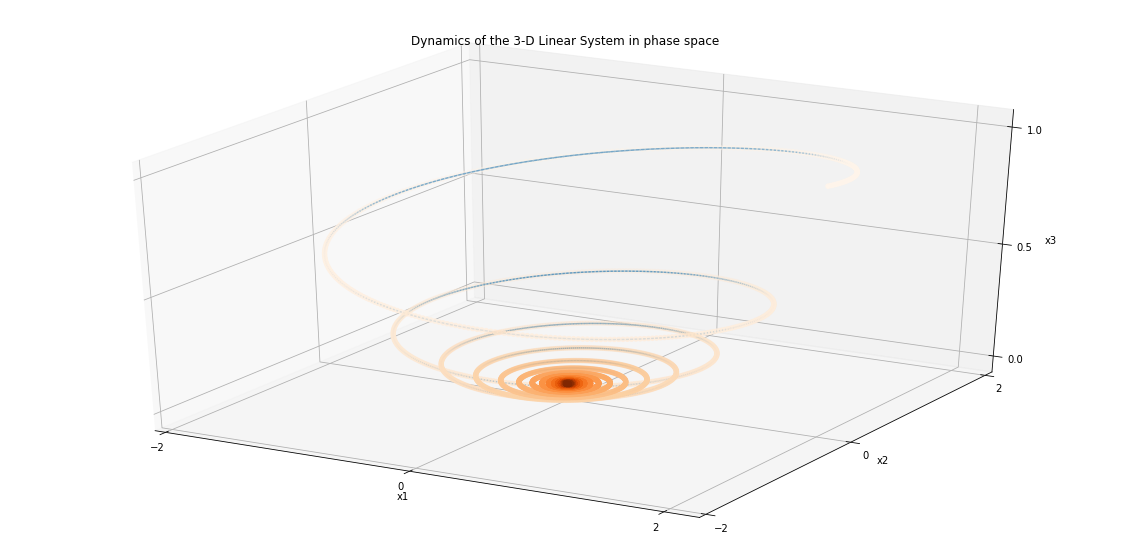

In [17]:
# Phase portrait
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(linear_data[0,:,0], linear_data[0,:,1], linear_data[0,:,2], c=time_points, cmap='Oranges')
ax.plot3D(predicted_traj[:,0], predicted_traj[:,1], predicted_traj[:,2])
#ax.grid(False)
ax.set_title('Dynamics of the 3-D Linear System in phase space')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_xticks([-2,0, 2 ])
ax.set_yticks([-2,0, 2 ])
ax.set_zticks([0, 0.5, 1])
plt.show()

In [16]:
epochs = 10000
net.train(epochs)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Time: 0.03, Loss: 5.4792e-02
Epoch: 100, Time: 1.74, Loss: 1.4290e-04
Epoch: 200, Time: 3.44, Loss: 1.0488e-04
Epoch: 300, Time: 5.16, Loss: 7.2229e-05
Epoch: 400, Time: 6.82, Loss: 4.8472e-05
Epoch: 500, Time: 8.47, Loss: 3.2729e-05
Epoch: 600, Time: 10.14, Loss: 2.2811e-05
Epoch: 700, Time: 11.80, Loss: 1.6714e-05
Epoch: 800, Time: 13.45, Loss: 1.2995e-05
Epoch: 900, Time: 15.10, Loss: 1.0711e-05
Epoch: 1000, Time: 16.76, Loss: 9.2693e-06
Epoch: 1100, Time: 18.44, Loss: 8.3072e-06
Epoch: 120

In [22]:
def ml_f(x):
    """
    Define the derivatives (RHS of the ODE) learned by ML
    """
    return np.ravel(net.predict(x.reshape(1,-1)))
    
# testing to see if it works
ml_f(bier_data[0,0,:])

array([-0.35538122,  0.1119963 ], dtype=float32)

In [23]:
# Solve the initial value problem given initial concentrations

predicted_traj = odeint(lambda x, t: ml_f(x), bier_data[0, 0,:], time_points)

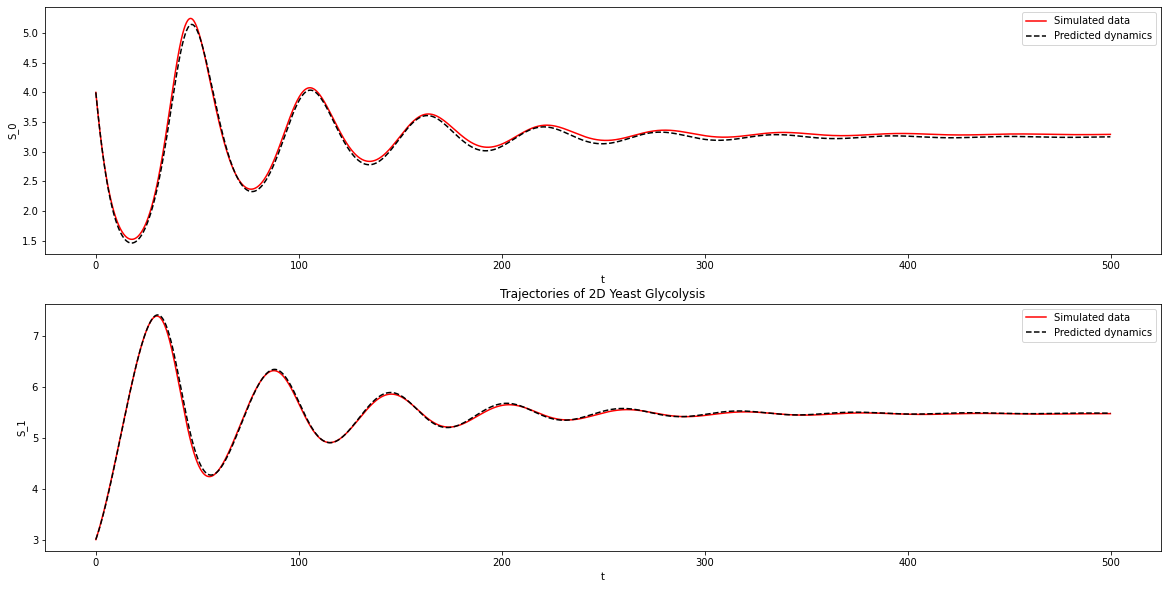

In [25]:
# plot and compare the predicted and true dynamics

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, bier_data[0, :, species], 'r-', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Yeast Glycolysis')
plt.show()

We see that the LmmNet is able to almost perfectly recover the dynamics of both species.

# Variants of LmmNet

In [1]:
import sys
sys.path.append("./source")
from model import *
from NovakTyson import *
from train import *
from predict import *
import matplotlib.pyplot as plt

In [5]:
# train the model
time_points, data_array = simulate_custom(step_size=0.4)

epochs = 10000
step_size = time_points[1] - time_points[0]
net = lmmNet_beta(step_size, data_array, M = 1, scheme='AM', hidden_units=256, loss_type='L1') # use trapezoidal rule (smallest error constant that is also stable)
net.train(epochs, debug=True)

# Solve the initial value problem given initial concentrations
predicted_traj = odeint(lambda x, t: predict_fn(x, t, net), data_array[0, 0,:], time_points)

Epoch: 0, Time: 0.12, Loss: 1.3119e+00
Epoch: 100, Time: 5.46, Loss: 1.0061e-01
Epoch: 200, Time: 10.63, Loss: 7.5115e-02
Epoch: 300, Time: 15.82, Loss: 7.0989e-02
Epoch: 400, Time: 21.20, Loss: 7.5680e-02
Epoch: 500, Time: 26.37, Loss: 8.1837e-02
Epoch: 600, Time: 31.56, Loss: 6.0136e-02
Epoch: 700, Time: 36.71, Loss: 6.0573e-02
Epoch: 800, Time: 41.87, Loss: 5.2468e-02
Epoch: 900, Time: 47.04, Loss: 4.5041e-02
Epoch: 1000, Time: 52.18, Loss: 4.6130e-02
Epoch: 1100, Time: 57.44, Loss: 4.7718e-02
Epoch: 1200, Time: 62.70, Loss: 4.5057e-02
Epoch: 1300, Time: 67.86, Loss: 5.2195e-02
Epoch: 1400, Time: 73.37, Loss: 3.8786e-02
Epoch: 1500, Time: 78.64, Loss: 3.6298e-02
Epoch: 1600, Time: 83.83, Loss: 4.1442e-02
Epoch: 1700, Time: 89.07, Loss: 3.8500e-02
Epoch: 1800, Time: 94.44, Loss: 5.7508e-02
Epoch: 1900, Time: 99.58, Loss: 4.9992e-02
Epoch: 2000, Time: 104.76, Loss: 4.5129e-02
Epoch: 2100, Time: 109.91, Loss: 5.3586e-02
Epoch: 2200, Time: 115.12, Loss: 4.5236e-02
Epoch: 2300, Time: 120

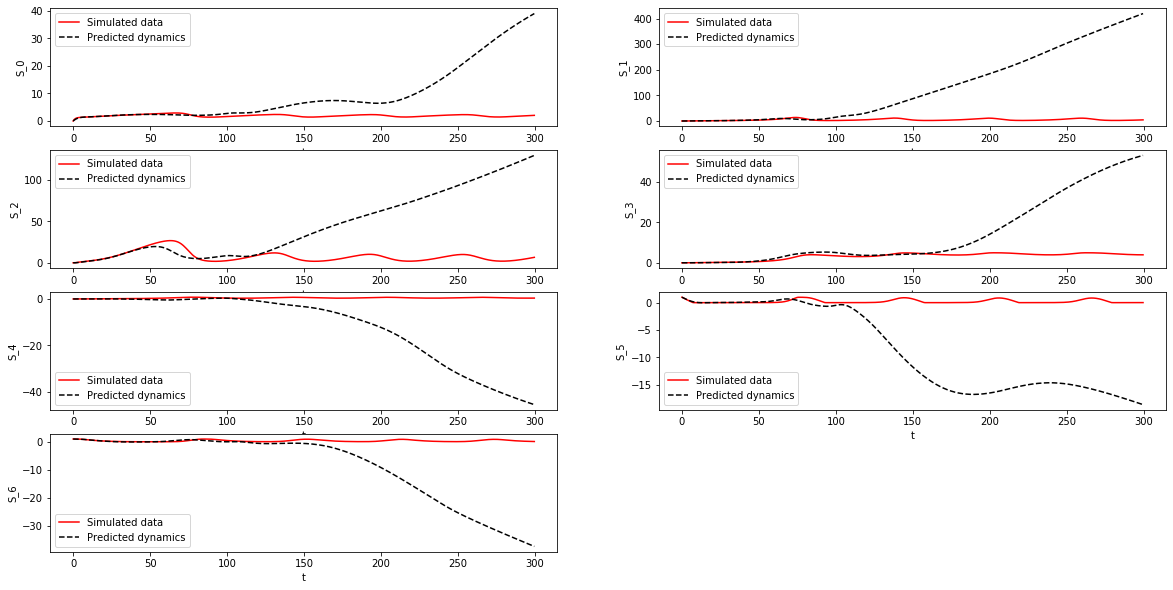

In [8]:
# plot and compare the predicted and true dynamics

plt.figure(figsize=(20, 10))
plt.title('Trajectories of Cell Cycle Model')

for species in range(7):
    plt.subplot(4,2,species + 1)
    plt.plot(time_points, data_array[0, :, species], 'r-', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.show()

In [9]:
# train the model
time_points, data_array = simulate_custom(step_size=3.0)

epochs = 10000
step_size = time_points[1] - time_points[0]
net = lmmNet_beta(step_size, data_array, M = 1, scheme='AM', hidden_units=256, loss_type='L1') # use trapezoidal rule (smallest error constant that is also stable)
net.train(epochs, debug=False)

# Solve the initial value problem given initial concentrations
predicted_traj = odeint(lambda x, t: predict_fn(x, t, net), data_array[0, 0,:], time_points)

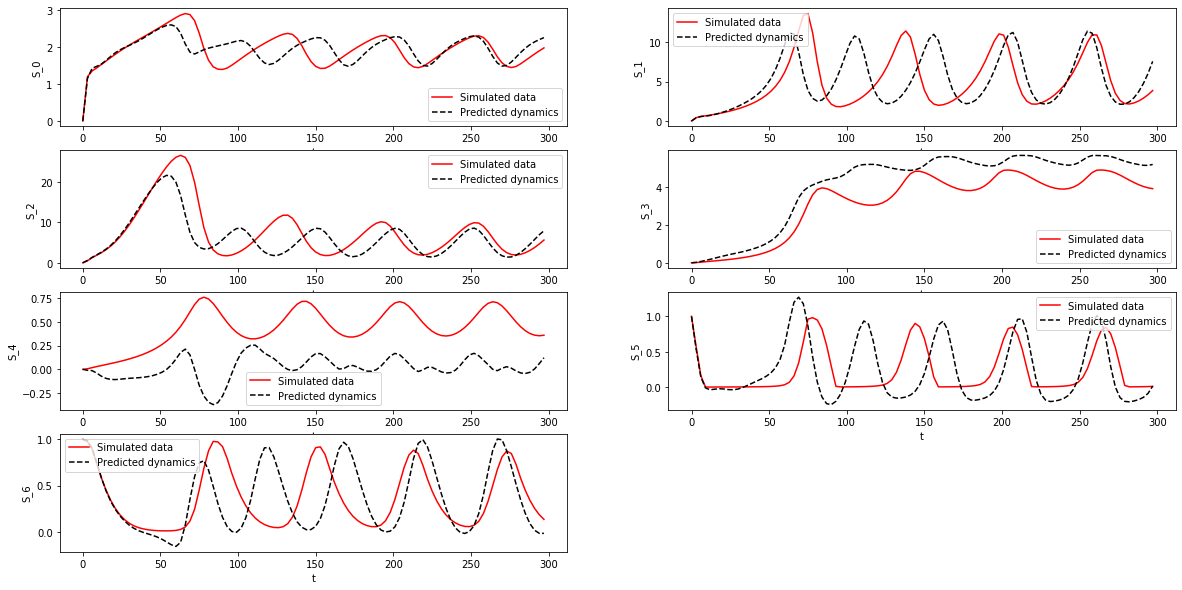

In [10]:
# plot and compare the predicted and true dynamics

plt.figure(figsize=(20, 10))
plt.title('Trajectories of Cell Cycle Model')

for species in range(7):
    plt.subplot(4,2,species + 1)
    plt.plot(time_points, data_array[0, :, species], 'r-', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.show()

In [2]:
# train the model
time_points, data_array = simulate_custom(step_size=2.5)

epochs = 10000
step_size = time_points[1] - time_points[0]
net = lmmNet_beta(step_size, data_array, M = 1, scheme='AM', hidden_units=256, loss_type='Wasserstein') # use trapezoidal rule (smallest error constant that is also stable)
net.train(epochs, debug=False)

# Solve the initial value problem given initial concentrations
predicted_traj = odeint(lambda x, t: predict_fn(x, t, net), data_array[0, 0,:], time_points)

ValueError: No gradients provided for any variable: ['dense_model/dense/kernel:0', 'dense_model/dense/bias:0', 'dense_model/dense_1/kernel:0', 'dense_model/dense_1/bias:0'].

RMSE: $||x_i - y_i||^2$

Wasserstein: minimum way to assign each $x_i$ to each $y_i$. This asssignment is equivalent to an optimal transport problem.